# `DataPipeline2`

1. `Embarked`: Dropped NA rows and applied OneHotEncoding
2. `Age`: Mean imputation with SimpleImputer 
3. `Sex`: OneHotEncoding
4. `Name`: Categorised into ['Mr', 'Mrs', 'Miss', 'Master', 'Special']<br/> 
    5.1 Rename [Mlle, Ms] -> Miss      
    5.2 Rename [Mme] -> Mrs     
    5.3 Put the Rest -> other     
    Then performed OneHotEncoding
5. `Ticket`: categorized into [1: numeric, 0: else] <br/>
    6.1 Remove special characters but not space <br/>
    6.2 Replace numeric strings by 'numeric' <br/>
    6.3 Split on space and keep the first item <br/>
 Then applied binarizer for [1: numeric, 0: else]
6. `SibSp`: binned into [0, 1, >1] using SibSpBinner
7. `Parch`: binned into [0, 1, >1] using ParchBinner
8. Scaling all features at the last

**MLmodel:** `SVC`

In [1]:
import pandas as pd
import numpy as np
from src.utils import load_data
dfX, dfy = load_data(return_X_y=True)

In [2]:
from sklearn.pipeline import Pipeline
from src.preprocessing import NaNDropper

## `prepare`

In [3]:
prepare_data = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

dfX_pre, dfy_pre = prepare_data.fit_transform(dfX, dfy)

## `preprocess`

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn_pandas import DataFrameMapper

In [15]:
from src.featurization import NameTitleExtractor, CabinTypeExtractor, TicketTypeExtractor
from src.featurization import SibSpBinner, ParchBinner 
from src.featurization import familySize, numCabin

In [31]:
imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder())
])


preprocess_noscale = ColumnTransformer([
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_enc', imp_enc, ['Embarked']),
    ('imp', SimpleImputer(), ['Age', 'Fare']),
    ('pre_Name', NameTitleExtractor(), 'Name'),
    ('cabin_type', CabinTypeExtractor(), 'Cabin'),
    ('cabin_num', numCabin, 'Cabin'),
    ('pre_Ticket', TicketTypeExtractor(), 'Ticket'),
    ('pre_SibSp', SibSpBinner(), ['SibSp']),
    ('pre_Parch', ParchBinner(), ['Parch']),
    ('familysize', familySize, ['SibSp', 'Parch'])
], 
    'passthrough')

preprocess_data = Pipeline([
    ('clmn_trnsfrm', preprocess_noscale),
    ('scale', StandardScaler())
])

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC

## `pipeline`

In [33]:
pipe = Pipeline([
    ('preprocess', preprocess_data),
    ('ml', SVC())
])
pipe.fit(dfX_pre, dfy_pre);

## training score

In [34]:
pipe.score(dfX_pre, dfy_pre)

0.8605174353205849

## Crossvalidation score

In [35]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
skf = StratifiedKFold(n_splits=5)
cross_val_score(pipe, dfX_pre, dfy_pre, cv=skf).mean()

0.8335555132355742

## Try various different ML models

implement a `try_various_models` function

In [43]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from src.plotting import plot_grid_results
from src.utils import print_params

In [13]:
default_models = [
    RidgeClassifier(),
    LogisticRegression(solver="liblinear"),  # liblinear is better for small datasets
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=1),
    SVC(),
    RandomForestClassifier(random_state=1),
    BaggingClassifier(random_state=1)
]

def print_best_param_score(search):
    print(f'Best param: {search.best_params_}', end="\n\n")
    print(f'Best score: {search.best_score_}')

def try_various_models(pipe, dfX, dfy, models='default', 
                       add_param_grid=None, search_type='grid', model_step='ml', plot=False, **kwargs):
    
    if models == 'default':
        param_grid = {model_step: default_models}
    else:
        param_grid = {model_step: models}
    
    if add_param_grid is not None:
        if type(add_param_grid) is dict:
            param_grid.update(add_param_grid)
        elif type(add_param_grid) is list:
            param_grid = [dict(pg, **param_grid) for pg in add_param_grid]
            
                
    if search_type == 'grid':
        search_cls = GridSearchCV
    elif search_type == 'rand':
        search_cls = RandomizedSearchCV
        
    search = search_cls(pipe, param_grid, **kwargs)
    search.fit(dfX, dfy)
    
    print_best_param_score(search)
    
    if plot:
        plot_grid_results(search, model_step)
        
    
    return search



    

Best param: {'ml': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)}

Best score: 0.8327600276191074


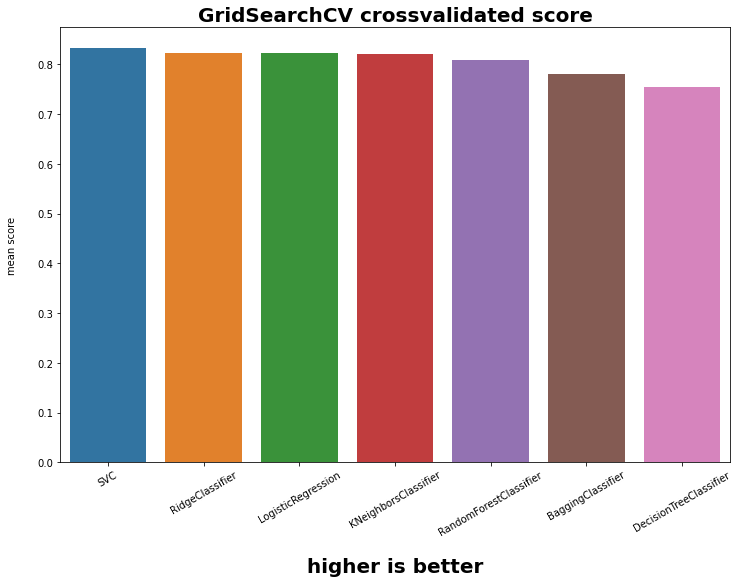

In [14]:
search = try_various_models(pipe, dfX, dfy, cv=skf, plot=True);

## Which models are affected by scaling?

In [174]:
search = try_various_models(pipe, dfX, dfy, 
                            add_param_grid={'preprocess__scale': [StandardScaler(), 'passthrough']})

Best param: {'ml': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'preprocess__scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best score: 0.8316301550436256


In [175]:
res = pd.DataFrame(search.cv_results_)
res.head()

res['ml_name'] = res.param_ml.apply(lambda x: x.__class__.__name__)

param = 'preprocess__scale'
best_param = res.loc[res.rank_test_score.argmin(), f'param_{param}']
order = res.loc[res[f'param_{param}'] == best_param, :].sort_values('rank_test_score')['ml_name'].tolist()

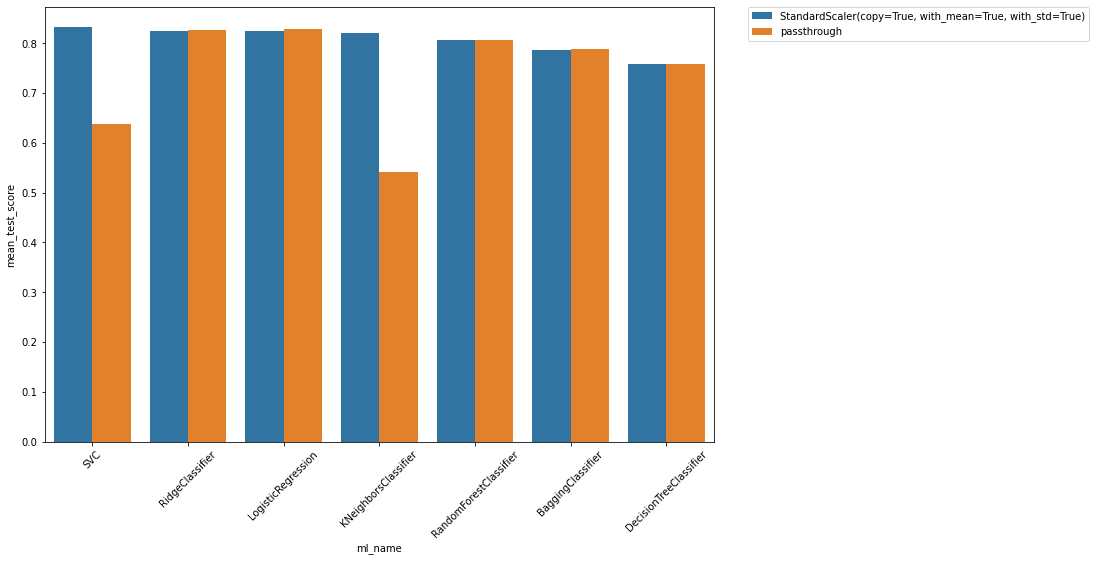

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
g = sns.barplot(x='ml_name', y='mean_test_score', hue='param_preprocess__scale', order=hue_order,
                data=res)

g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Comparing effect of multiple params

In [40]:
def compare_param_effect_models(pipe, dfX, dfy, param_steps,
                                models='default', model_step='ml', 
                                alt='passthrough', comb=False, **kwargs):
    
    pipe_params = pipe.get_params()
    
    if type(alt) is not list:
        alt_opts = [alt for i in range(len(pipe_params))]
    else:
        alt_opts = alt
    
    if comb:
        add_param_grid = {ps: [pipe_params[ps], alt_opts[i]] 
                          for i, ps in enumerate(param_steps)}
    else:
        add_param_grid = [{ps: [pipe_params[ps], alt_opts[i]]} 
                          for i, ps in enumerate(param_steps)]
        
        
    return try_various_models(pipe, dfX, dfy, models, add_param_grid, model_step=model_step, **kwargs)

In [39]:
def plot_param_effect_models(search, param_step, model_step='ml', labels=None):
    res = pd.DataFrame(search.cv_results_)

    res['ml_name'] = res[f'param_{model_step}'].apply(lambda x: x.__class__.__name__)
        
    param_col = f'param_{param_step}'
    valid_idx = ~res[param_col].isna()
    valid_res = res.loc[valid_idx, :]
    index_best = valid_res.index[valid_res.rank_test_score.argmin()]

    best_param = valid_res.loc[index_best, param_col]

    order = (res.loc[res[f'param_{param_step}'] == best_param, :]
             .sort_values('rank_test_score')['ml_name'].tolist())
    
    plt.figure(figsize=(12, 8))
    g = sns.barplot(x='ml_name', y='mean_test_score', hue=f'param_{param_step}', order=order,
                data=res)

    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if labels is not None:
        for t, l in zip(g.legend_.texts, labels): t.set_text(l)

    
    return g

In [265]:
param_steps1 = [f'preprocess__clmn_trnsfrm__pre_{ps}' 
               for ps in ['Name', 'Cabin', 'Ticket', 'SibSp', 'Parch']] + ['preprocess__clmn_trnsfrm__familySize']

param_steps1

search1 = compare_param_effect_models(pipe, dfX, dfy, 
                                     param_steps1, 
                                     alt='drop', comb=False)

res1 = pd.DataFrame(search1.cv_results_)

['preprocess__clmn_trnsfrm__pre_Name',
 'preprocess__clmn_trnsfrm__pre_Cabin',
 'preprocess__clmn_trnsfrm__pre_Ticket',
 'preprocess__clmn_trnsfrm__pre_SibSp',
 'preprocess__clmn_trnsfrm__pre_Parch',
 'preprocess__clmn_trnsfrm__familysize']

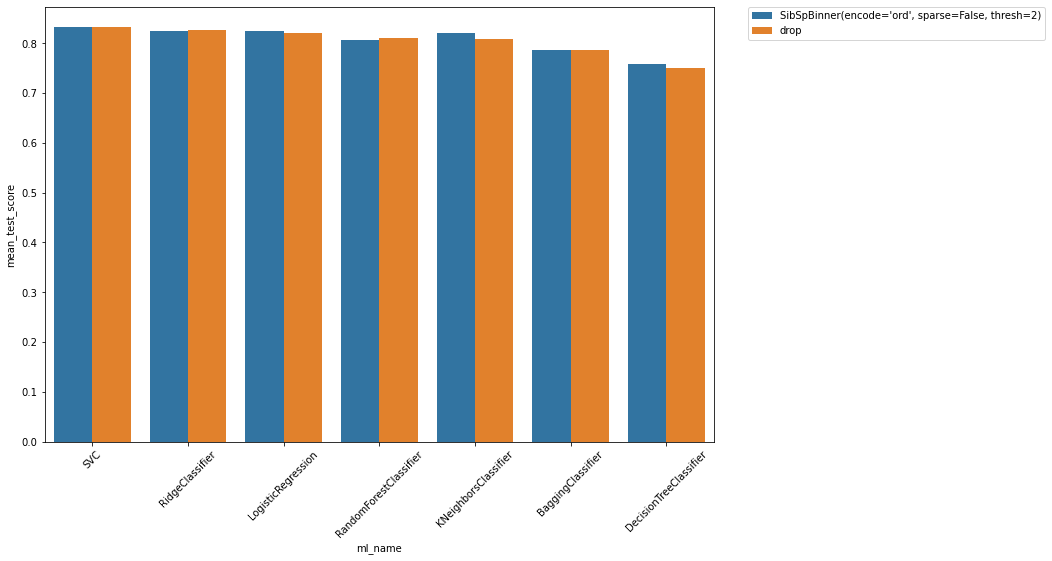

In [325]:
plot_param_effect_models(search1, 'preprocess__clmn_trnsfrm__pre_SibSp')

In [322]:
param_steps2 = ['preprocess__scale', 'preprocess__clmn_trnsfrm__imp_enc__enc']
alt = ['passthrough', OrdinalEncoder()]
search2 = compare_param_effect_models(pipe, dfX, dfy, param_steps2, alt=alt, comb=False)

Best param: {'ml': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'preprocess__clmn_trnsfrm__imp_enc__enc': OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)}

Best score: 0.8361182599962339


In [323]:
res = pd.DataFrame(search2.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml,param_preprocess__scale,param_preprocess__clmn_trnsfrm__imp_enc__enc,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035969,0.007121,0.020320,0.001655,"RidgeClassifier(alpha=1.0, class_weight=None, ...","StandardScaler(copy=True, with_mean=True, with...",NaN,"{'ml': RidgeClassifier(alpha=1.0, class_weight...",0.821229,0.825843,0.825843,0.797753,0.848315,0.823796,0.016090,7
1,0.031742,0.000268,0.019188,0.000079,"RidgeClassifier(alpha=1.0, class_weight=None, ...",passthrough,NaN,"{'ml': RidgeClassifier(alpha=1.0, class_weight...",0.826816,0.825843,0.825843,0.797753,0.853933,0.826037,0.017770,5
2,0.033054,0.004301,0.018078,0.001700,"LogisticRegression(C=1.0, class_weight=None, d...","StandardScaler(copy=True, with_mean=True, with...",NaN,"{'ml': LogisticRegression(C=1.0, class_weight=...",0.826816,0.808989,0.814607,0.808989,0.859551,0.823790,0.019029,9
3,0.029871,0.004767,0.015739,0.000089,"LogisticRegression(C=1.0, class_weight=None, d...",passthrough,NaN,"{'ml': LogisticRegression(C=1.0, class_weight=...",0.837989,0.825843,0.820225,0.820225,0.865169,0.833890,0.016932,2
4,0.027192,0.002113,0.024026,0.000559,"KNeighborsClassifier(algorithm='auto', leaf_si...","StandardScaler(copy=True, with_mean=True, with...",NaN,"{'ml': KNeighborsClassifier(algorithm='auto', ...",0.821229,0.808989,0.820225,0.797753,0.853933,0.820426,0.018806,12


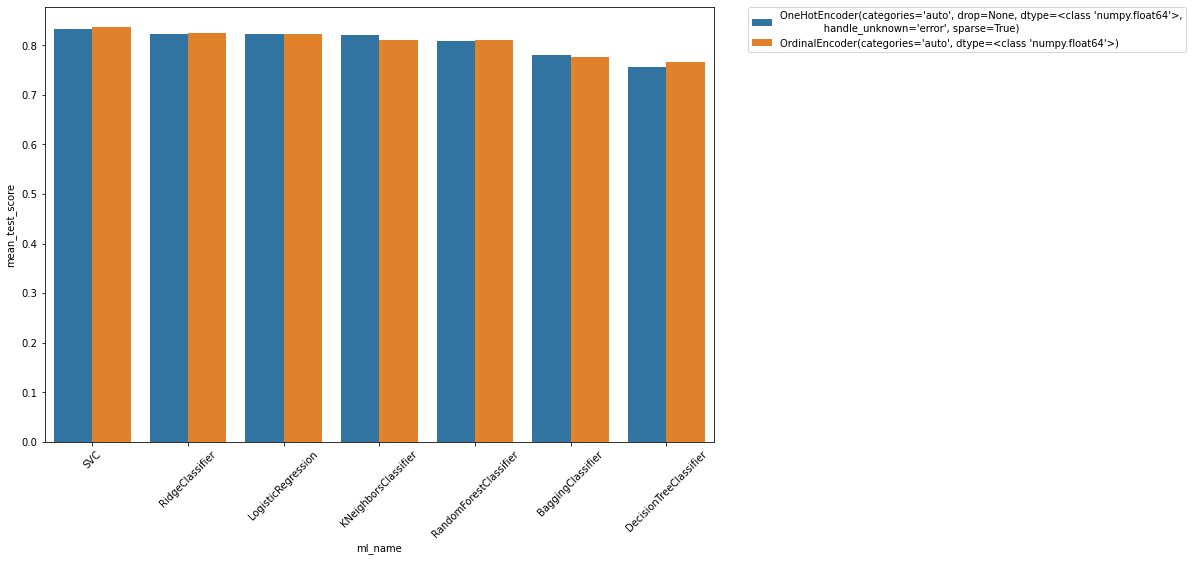

In [324]:
plot_param_effect_models(search2, 'preprocess__clmn_trnsfrm__imp_enc__enc')

## Did adding `numCabin` help?

In [48]:
search = compare_param_effect_models(pipe, dfX, dfy, ['preprocess__clmn_trnsfrm__cabin_num'], alt='drop')

Best param: {'ml': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'preprocess__clmn_trnsfrm__cabin_num': FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function get_num_cabin at 0x7fd86a56a9d0>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    validate=False)}

Best score: 0.8338836231247253


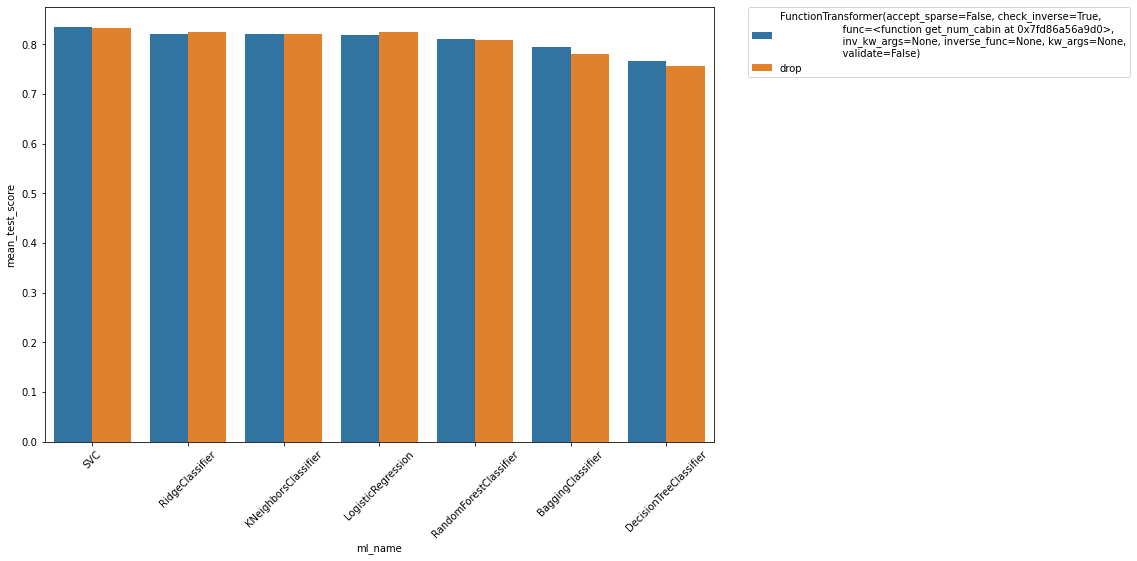

In [53]:
plot_param_effect_models(search, 'preprocess__c  lmn_trnsfrm__cabin_num')